In [0]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www-eu.apache.org/dist/spark/spark-2.4.4/spark-2.4.4-bin-hadoop2.7.tgz
!tar xf spark-2.4.4-bin-hadoop2.7.tgz
!pip install -q findspark

In [0]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.4-bin-hadoop2.7"

In [0]:
import findspark
findspark.init("spark-2.4.4-bin-hadoop2.7")# SPARK_HOME
from pyspark.sql import SparkSession
spark= SparkSession.builder.master("local[*]").getOrCreate()
import pyspark.sql as sparksql
sc= spark.sparkContext

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
#print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [0]:
from pyspark.sql import SparkSession
import pyspark.sql as sparksql
spark = SparkSession.builder.appName('stroke').getOrCreate()
train = spark.read.csv('train_2v.csv', inferSchema=True,header=True)
test = spark.read.csv('test_2v.csv', inferSchema=True,header=True)

### Exploring the training data

In [6]:
train.printSchema()

root
 |-- id: integer (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- hypertension: integer (nullable = true)
 |-- heart_disease: integer (nullable = true)
 |-- ever_married: string (nullable = true)
 |-- work_type: string (nullable = true)
 |-- Residence_type: string (nullable = true)
 |-- avg_glucose_level: double (nullable = true)
 |-- bmi: double (nullable = true)
 |-- smoking_status: string (nullable = true)
 |-- stroke: integer (nullable = true)



In [7]:
train.dtypes

[('id', 'int'),
 ('gender', 'string'),
 ('age', 'double'),
 ('hypertension', 'int'),
 ('heart_disease', 'int'),
 ('ever_married', 'string'),
 ('work_type', 'string'),
 ('Residence_type', 'string'),
 ('avg_glucose_level', 'double'),
 ('bmi', 'double'),
 ('smoking_status', 'string'),
 ('stroke', 'int')]

In [8]:
train.describe().show()

+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|summary|               id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|             stroke|
+-------+-----------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|  count|            43400| 43400|             43400|              43400|              43400|       43400|    43400|         43400|             43400|             41938|          30108|              43400|
|   mean|36326.14235023042|  null| 42.21789400921646|0.09357142857142857|0.04751152073732719|        null|     null|          null|104.48274999999916|28.605038390004545|       

In [9]:
train.toPandas().head(5)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,30669,Male,3.0,0,0,No,children,Rural,95.12,18.0,None,0
1,30468,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
2,16523,Female,8.0,0,0,No,Private,Urban,110.89,17.6,None,0
3,56543,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
4,46136,Male,14.0,0,0,No,Never_worked,Rural,161.28,19.1,None,0


### Lets also look at test data

In [10]:
test.describe().show()

+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+------------------+---------------+
|summary|                id|gender|               age|       hypertension|       heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|
+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+------------------+---------------+
|  count|             18601| 18601|             18601|              18601|               18601|       18601|    18601|         18601|             18601|             18010|          12850|
|   mean| 36747.36804472878|  null|42.056504489006024|0.09316703403042847|0.048061932154185256|        null|     null|          null| 104.3863593355191|28.545324819544625|           null|
| stddev|21053.151123778684|  null|22.528017622414048|0.2906

###Detect missing value

In [11]:
#train data
train_mv = train.toPandas()
train_mv.isnull().sum() #/len(train_mv)*100

id                       0
gender                   0
age                      0
hypertension             0
heart_disease            0
ever_married             0
work_type                0
Residence_type           0
avg_glucose_level        0
bmi                   1462
smoking_status       13292
stroke                   0
dtype: int64

In [12]:
#test data
test_mv = test.toPandas()
test_mv.isnull().sum() #/len(test_mv)*100

id                      0
gender                  0
age                     0
hypertension            0
heart_disease           0
ever_married            0
work_type               0
Residence_type          0
avg_glucose_level       0
bmi                   591
smoking_status       5751
dtype: int64

### Lets look the the target distribution

In [13]:
train.groupBy('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     1|  783|
|     0|42617|
+------+-----+



As can be seen from this observation. This is an Imbalanced dataset, where the number of observations belonging to one class is significantly lower than those belonging to the other classes. In this case, the predictive model could be biased and inaccurate. There are different strategies to handling Imbalanced Datasets, We will look into it later.

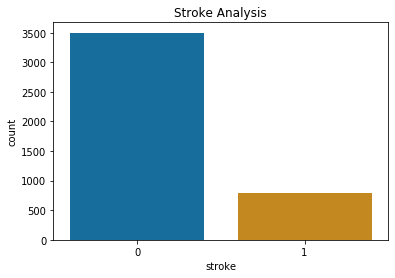

In [14]:
## DATA UNDERSAMPLING PROCESS
stroke = train.toPandas()
shuffled_data = stroke.sample(frac=1,random_state=4)
stroke_df = stroke.loc[stroke['stroke'] == 1]
non_stroke_df = stroke.loc[stroke['stroke'] == 0].sample(n= 3500,random_state= 101)
# non-stroke sufferers were reduced to 3500 to balance the data set.
normalized_stroke = pd.concat([stroke_df, non_stroke_df])
sns.countplot('stroke', data= normalized_stroke, palette= "colorblind")
plt.title('Stroke Analysis')
plt.show()

In [15]:
merge_frames = [stroke_df, non_stroke_df]

train_df = pd.concat(merge_frames)
train_df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
63,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
81,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
141,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
257,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
264,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
14934,68854,Male,27.0,0,0,No,Private,Rural,145.32,27.2,smokes,0
15502,72470,Female,65.0,0,0,Yes,Private,Urban,61.24,39.4,None,0
18589,4567,Female,21.0,0,0,No,Private,Rural,80.11,34.3,never smoked,0
15622,66236,Female,32.0,0,0,No,Govt_job,Rural,60.16,35.6,never smoked,0


In [16]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(sc)
train_ds = sqlContext.createDataFrame(train_df)

type(train_ds)

pyspark.sql.dataframe.DataFrame

In [17]:
train_ds.groupBy('stroke').count().show()

+------+-----+
|stroke|count|
+------+-----+
|     0| 3500|
|     1|  783|
+------+-----+



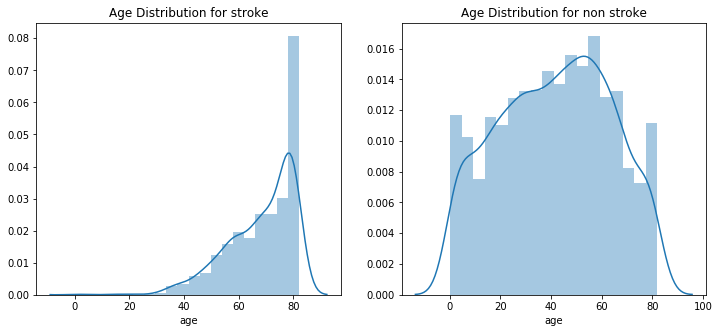

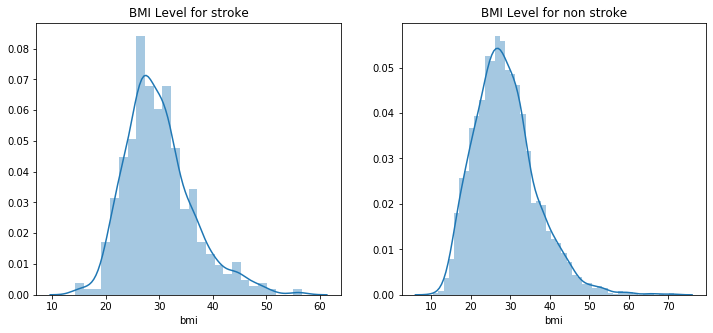

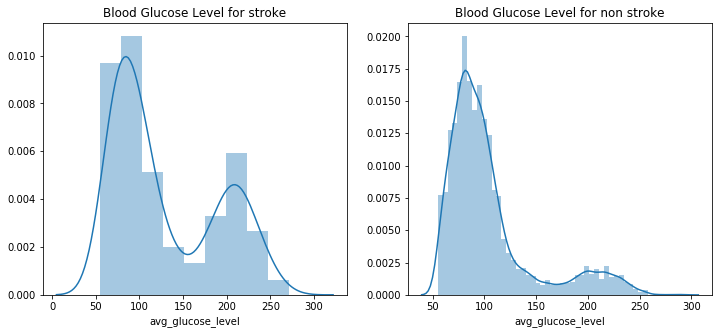

In [18]:
# Count plot to check subjects

#age
fig,axes_age = plt.subplots(1,2, figsize=(12,5))
sns.distplot(stroke_df.age, ax=axes_age[0])
axes_age[0].set_title('Age Distribution for stroke')
sns.distplot(non_stroke_df.age, ax=axes_age[1])
axes_age[1].set_title('Age Distribution for non stroke')
plt.show()

#bmi
fig,axes_age = plt.subplots(1,2, figsize=(12,5))
sns.distplot(stroke_df.bmi.dropna(), ax=axes_age[0])
axes_age[0].set_title('BMI Level for stroke')
sns.distplot(non_stroke_df.bmi.dropna(), ax=axes_age[1])
axes_age[1].set_title('BMI Level for non stroke')
plt.show()

#Blood Glucose Level
fig,axes_glu=plt.subplots(1,2, figsize=(12,5))
sns.distplot(stroke_df.avg_glucose_level.dropna(), ax=axes_glu[0])
axes_glu[0].set_title('Blood Glucose Level for stroke')
sns.distplot(non_stroke_df.avg_glucose_level.dropna(), ax=axes_glu[1])
axes_glu[1].set_title('Blood Glucose Level for non stroke')
plt.show()


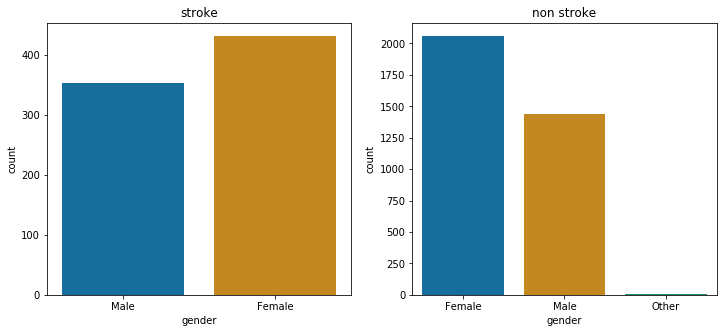

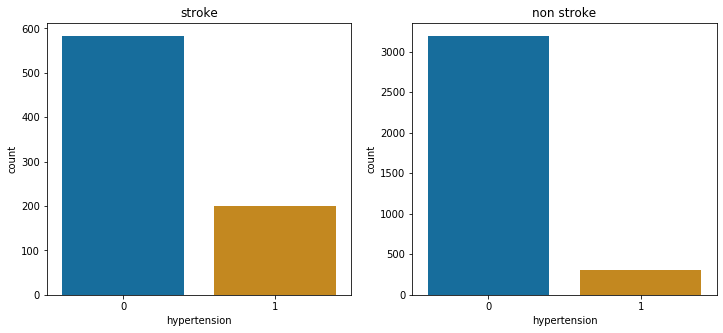

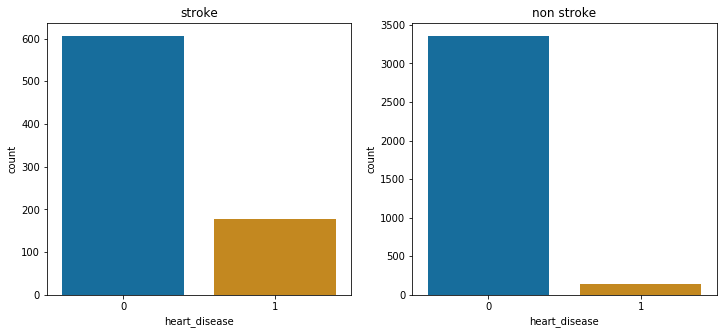

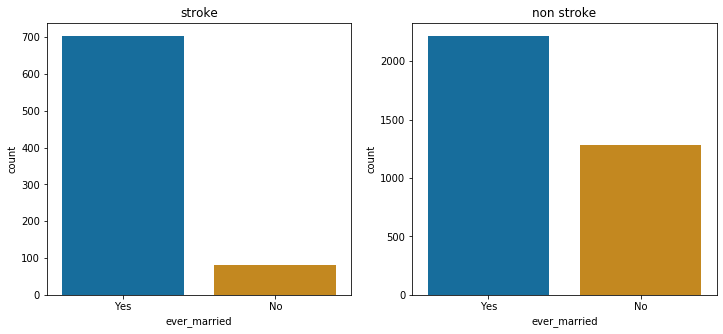

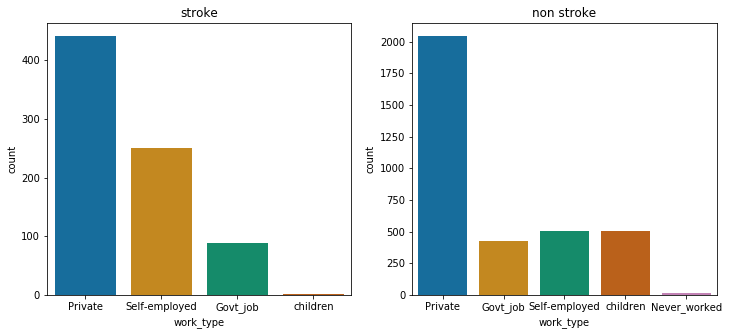

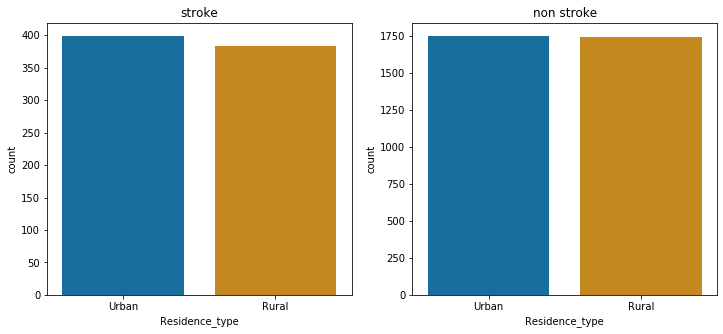

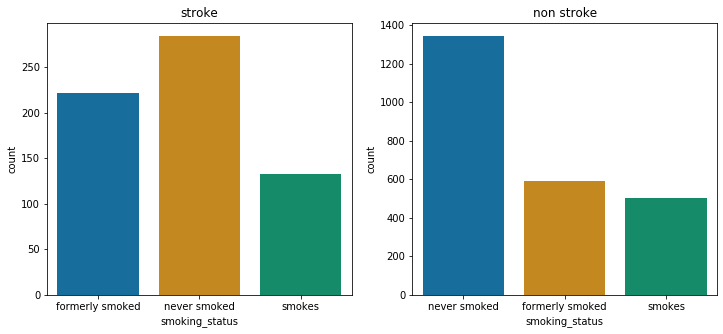

In [19]:
#gender
fig,axes_gender = plt.subplots(1,2, figsize=(12,5))
sns.countplot(stroke_df.gender, palette= "colorblind", ax=axes_gender[0])
axes_gender[0].set_title('stroke')
sns.countplot(non_stroke_df.gender, palette= "colorblind", ax=axes_gender[1])
axes_gender[1].set_title('non stroke')
plt.show()

#hypertension
fig,axes_hyp = plt.subplots(1,2, figsize=(12,5))
sns.countplot(stroke_df.hypertension, palette= "colorblind", ax=axes_hyp[0])
axes_hyp[0].set_title('stroke')
sns.countplot(non_stroke_df.hypertension, palette= "colorblind", ax=axes_hyp[1])
axes_hyp[1].set_title('non stroke')
plt.show()

#heart_disease
fig,axes_heart = plt.subplots(1,2, figsize=(12,5))
sns.countplot(stroke_df.heart_disease, palette= "colorblind", ax=axes_heart[0])
axes_heart[0].set_title('stroke')
sns.countplot(non_stroke_df.heart_disease, palette= "colorblind", ax=axes_heart[1])
axes_heart[1].set_title('non stroke')
plt.show()

#ever_married	
fig,axes_em = plt.subplots(1,2, figsize=(12,5))
sns.countplot(stroke_df.ever_married, palette= "colorblind", ax=axes_em[0])
axes_em[0].set_title('stroke')
sns.countplot(non_stroke_df.ever_married, palette= "colorblind", ax=axes_em[1])
axes_em[1].set_title('non stroke')
plt.show()

#work_type
fig,axes_work = plt.subplots(1,2, figsize=(12,5))
sns.countplot(stroke_df.work_type, palette= "colorblind", ax=axes_work[0])
sns.countplot(non_stroke_df.work_type, palette= "colorblind", ax=axes_work[1])
axes_work[0].set_title('stroke')
axes_work[1].set_title('non stroke')
plt.show()

#Residence_type	
fig,axes_rt = plt.subplots(1,2, figsize=(12,5))
sns.countplot(stroke_df.Residence_type, palette= "colorblind", ax=axes_rt[0])
sns.countplot(non_stroke_df.Residence_type, palette= "colorblind", ax=axes_rt[1])
axes_rt[0].set_title('stroke')
axes_rt[1].set_title('non stroke')
plt.show()

#smoking_status
fig,axes_ss = plt.subplots(1,2, figsize=(12,5))
sns.countplot(stroke_df.smoking_status.dropna(), palette= "colorblind", ax=axes_ss[0])
sns.countplot(non_stroke_df.smoking_status.dropna(), palette= "colorblind", ax=axes_ss[1])
axes_ss[0].set_title('stroke')
axes_ss[1].set_title('non stroke')
plt.show()


###Correlation

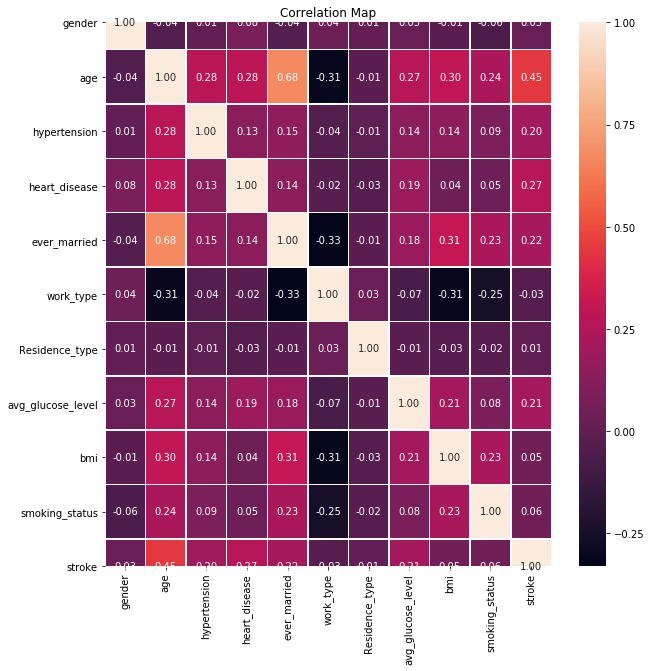

In [143]:
train_corr = train_ds.toPandas()

train_corr['smoking_status'] = train_corr['smoking_status'].astype('category').cat.codes
train_corr['ever_married'] = train_corr['ever_married'].astype('category').cat.codes
train_corr['work_type'] = train_corr['work_type'].astype('category').cat.codes
train_corr['Residence_type'] = train_corr['Residence_type'].astype('category').cat.codes
train_corr['gender'] = train_corr['gender'].astype('category').cat.codes

#print(train_corr)

train_corr = train_corr.drop('id', axis = 1)
f,ax=plt.subplots(figsize = (10,10))
sns.heatmap(train_corr.corr(),annot= True,linewidths=0.5,fmt = ".2f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

### Training feature analysis 

In [0]:
# create DataFrame as a temporary view for SQL queries
train.createOrReplaceTempView('table')

influence of work type on getting stroke

In [145]:
# sql query to find the number of people in specific work_type who have had stroke and not
spark.sql("SELECT work_type, COUNT(work_type) as work_type_count FROM table WHERE stroke == 1 GROUP BY work_type ORDER BY COUNT(work_type) DESC").show()
spark.sql("SELECT work_type, COUNT(work_type) as work_type_count FROM table WHERE stroke == 0 GROUP BY work_type ORDER BY COUNT(work_type) DESC").show()

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|            441|
|Self-employed|            251|
|     Govt_job|             89|
|     children|              2|
+-------------+---------------+

+-------------+---------------+
|    work_type|work_type_count|
+-------------+---------------+
|      Private|          24393|
|Self-employed|           6542|
|     children|           6154|
|     Govt_job|           5351|
| Never_worked|            177|
+-------------+---------------+



It is mostly happening to private or self-employed person.

influence of smoking status on getting stroke

In [23]:
spark.sql("SELECT smoking_status, COUNT(smoking_status) as smoking_status_count FROM table WHERE stroke == 1 GROUP BY smoking_status ORDER BY COUNT(smoking_status) DESC").show()
spark.sql("SELECT smoking_status, COUNT(smoking_status) as smoking_status_count FROM table WHERE stroke == 0 GROUP BY smoking_status ORDER BY COUNT(smoking_status) DESC").show()

+---------------+--------------------+
| smoking_status|smoking_status_count|
+---------------+--------------------+
|   never smoked|                 284|
|formerly smoked|                 221|
|         smokes|                 133|
|           null|                   0|
+---------------+--------------------+

+---------------+--------------------+
| smoking_status|smoking_status_count|
+---------------+--------------------+
|   never smoked|               15769|
|formerly smoked|                7272|
|         smokes|                6429|
|           null|                   0|
+---------------+--------------------+



influence of marrage on getting stroke

In [24]:
spark.sql("SELECT ever_married, COUNT(ever_married) as ever_married_count FROM table WHERE stroke == 1 GROUP BY ever_married ORDER BY COUNT(ever_married) DESC").show()
spark.sql("SELECT ever_married, COUNT(ever_married) as ever_married_count FROM table WHERE stroke == 0 GROUP BY ever_married ORDER BY COUNT(ever_married) DESC").show()

+------------+------------------+
|ever_married|ever_married_count|
+------------+------------------+
|         Yes|               703|
|          No|                80|
+------------+------------------+

+------------+------------------+
|ever_married|ever_married_count|
+------------+------------------+
|         Yes|             27235|
|          No|             15382|
+------------+------------------+



Is it related to gender !!!

In [25]:
spark.sql("SELECT gender, COUNT(gender) as gender_count, COUNT(gender)*100/(SELECT COUNT(gender) FROM table WHERE gender == 'Male') as percentage FROM table WHERE stroke== 1 AND gender = 'Male' GROUP BY gender").show()
spark.sql("SELECT gender, COUNT(gender) as gender_count, COUNT(gender)*100/(SELECT COUNT(gender) FROM table WHERE gender == 'Female') as percentage FROM table WHERE stroke== 1 AND gender = 'Female' GROUP BY gender").show()

+------+------------+------------------+
|gender|gender_count|        percentage|
+------+------------+------------------+
|  Male|         352|1.9860076732114647|
+------+------------+------------------+

+------+------------+------------------+
|gender|gender_count|        percentage|
+------+------------+------------------+
|Female|         431|1.6793298266121177|
+------+------------+------------------+



1.68% male and almost 2% male had stroke.

Now we will see influence of age on stroke

In [26]:
spark.sql("SELECT COUNT(age)*100/(SELECT COUNT(age) FROM table WHERE stroke ==1) as percentage FROM table WHERE stroke == 1 AND age>=50").show()

+-----------------+
|       percentage|
+-----------------+
|91.57088122605364|
+-----------------+



Here we see that 91.5% stroke had occured for person who are more than 50 years old

### Cleaning up training data

In [27]:
train_ds.describe().show()

+-------+------------------+------+-----------------+------------------+-------------------+------------+---------+--------------+------------------+----+---------------+-------------------+
|summary|                id|gender|              age|      hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level| bmi| smoking_status|             stroke|
+-------+------------------+------+-----------------+------------------+-------------------+------------+---------+--------------+------------------+----+---------------+-------------------+
|  count|              4283|  4283|             4283|              4283|               4283|        4283|     4283|          4283|              4283|4283|           3073|               4283|
|   mean| 36184.19472332477|  null|46.26733597945366|0.1183749708148494|0.07494746672892832|        null|     null|          null|108.77480504319395| NaN|           null|0.18281578332944198|
| stddev|21269.635900864585|  null|23.0816107

1. Here we see that there are few missing values in *smoking_status* and *bmi* column
2. Also there are few categorical data (*gender, ever_married, work_type, Residence_type, smoking_status* which we need to covert into one hot encoding

####Impute missing values

In [0]:
# fill in missing values for smoking status
# As this is categorical data, we will add one data type "No Info" for the missing one
train_f = train_ds.na.fill('No Info', subset=['smoking_status'])
test_f = test.na.fill('No Info', subset=['smoking_status'])

In [0]:
#calculate mean of bmi
from pyspark.sql.functions import mean
train_bmi = train_ds.select(train_ds.bmi)
train_bmi = train_bmi.na.drop()
mean = train_bmi.select(mean(train_bmi['bmi'])).collect()
mean_bmi = mean[0][0]

In [0]:
# fill in miss values for bmi
train_f = train_f.na.fill(mean_bmi,['bmi'])
test_f = test_f.na.fill(mean_bmi,['bmi'])

In [31]:
train_f.describe().show()


+-------+------------------+------+-----------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|summary|                id|gender|              age|      hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|             stroke|
+-------+------------------+------+-----------------+------------------+-------------------+------------+---------+--------------+------------------+------------------+--------------+-------------------+
|  count|              4283|  4283|             4283|              4283|               4283|        4283|     4283|          4283|              4283|              4283|          4283|               4283|
|   mean| 36184.19472332477|  null|46.26733597945366|0.1183749708148494|0.07494746672892832|        null|     null|          null|108.77480504319395|28.954617874035343|          null|0

In [32]:
test_f.describe().show()

+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+------------------+--------------+
|summary|                id|gender|               age|       hypertension|       heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi|smoking_status|
+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+------------------+--------------+
|  count|             18601| 18601|             18601|              18601|               18601|       18601|    18601|         18601|             18601|             18601|         18601|
|   mean| 36747.36804472878|  null|42.056504489006024|0.09316703403042847|0.048061932154185256|        null|     null|          null| 104.3863593355191|28.558329077122657|          null|
| stddev|21053.151123778684|  null|22.528017622414048|0.290674182

correlation after imputation

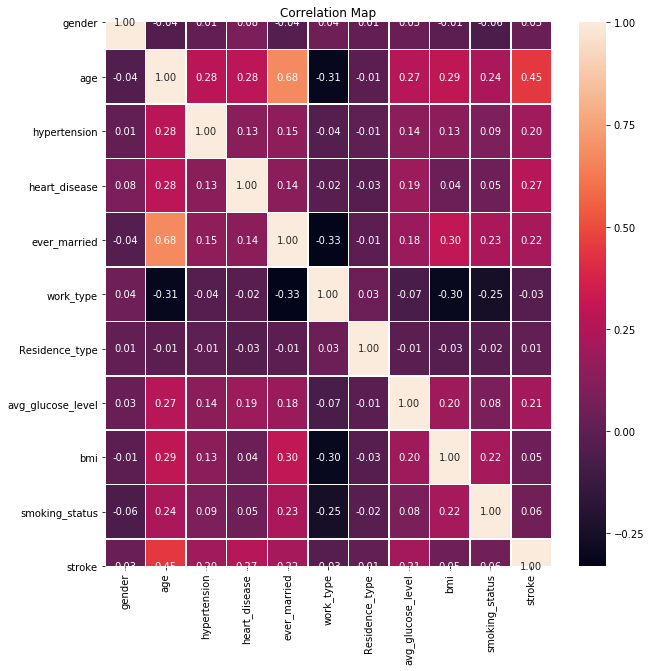

In [33]:
train_corr_f = train_f.toPandas()

train_corr_f['smoking_status'] = train_corr_f['smoking_status'].astype('category').cat.codes
train_corr_f['ever_married'] = train_corr_f['ever_married'].astype('category').cat.codes
train_corr_f['work_type'] = train_corr_f['work_type'].astype('category').cat.codes
train_corr_f['Residence_type'] = train_corr_f['Residence_type'].astype('category').cat.codes
train_corr_f['gender'] = train_corr_f['gender'].astype('category').cat.codes

train_corr_f = train_corr_f.drop('id', axis = 1)
f,ax=plt.subplots(figsize = (10,10))
sns.heatmap(train_corr_f.corr(),annot= True,linewidths=0.5,fmt = ".2f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

Outlier after imputation

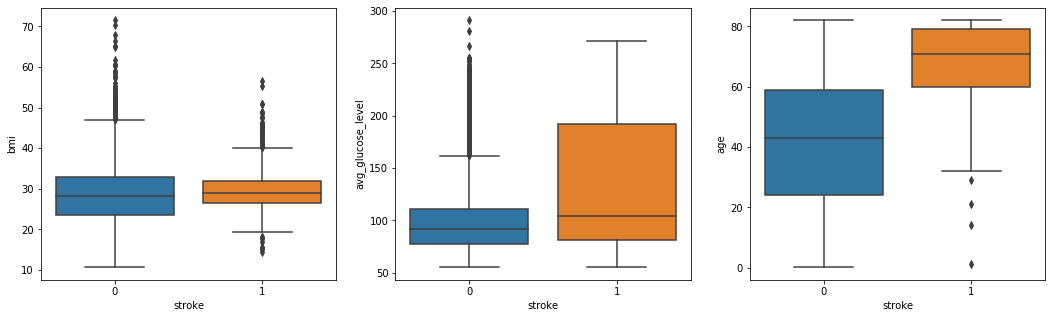

In [34]:
outlier_impute = train_f.toPandas()

fig, axes_out_im = plt.subplots(1,3, figsize=(18,5))

sns.boxplot(x = "stroke", y = "bmi", data=outlier_impute, ax=axes_out_im[0])
sns.boxplot(x = "stroke", y = "avg_glucose_level", data=outlier_impute,ax=axes_out_im[1])
sns.boxplot(x = "stroke", y = "age", data=outlier_impute,ax=axes_out_im[2])
plt.show()

####Delete rows which has missing values

In [35]:
train_delete = train_ds.na.drop()
train_delete.describe().show()

+-------+------------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|summary|                id|gender|               age|       hypertension|      heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|               bmi| smoking_status|             stroke|
+-------+------------------+------+------------------+-------------------+-------------------+------------+---------+--------------+------------------+------------------+---------------+-------------------+
|  count|              2901|  2901|              2901|               2901|               2901|        2901|     2901|          2901|              2901|              2901|           2901|               2901|
|   mean|  37383.1647707687|  null| 51.04308859014133|0.13960703205791106|0.08100654946570149|        null|     null|          null|111.43634264046887|30.250534298517753|  

In [36]:
test_delete = test.na.drop()
test_delete.describe().show()

+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+-----------------+---------------+
|summary|                id|gender|               age|       hypertension|       heart_disease|ever_married|work_type|Residence_type| avg_glucose_level|              bmi| smoking_status|
+-------+------------------+------+------------------+-------------------+--------------------+------------+---------+--------------+------------------+-----------------+---------------+
|  count|             12423| 12423|             12423|              12423|               12423|       12423|    12423|         12423|             12423|            12423|          12423|
|   mean|37139.647911132575|  null|47.573210979634545|0.11188923770425824|0.052000321983417856|        null|     null|          null|106.55493359092029|30.08220236657801|           null|
| stddev|20821.226259445666|  null|18.730673320972677|0.315242820

correlation after deletion

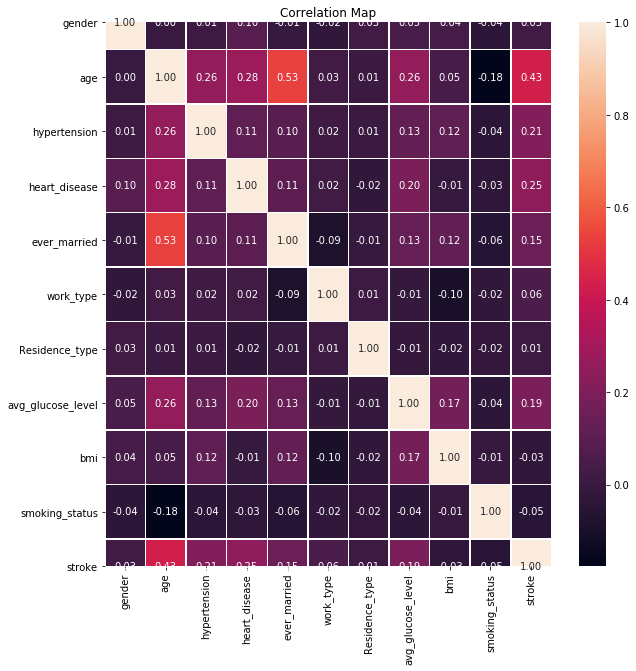

In [37]:
train_corr_delete = train_delete.toPandas()

train_corr_delete['smoking_status'] = train_corr_delete['smoking_status'].astype('category').cat.codes
train_corr_delete['ever_married'] = train_corr_delete['ever_married'].astype('category').cat.codes
train_corr_delete['work_type'] = train_corr_delete['work_type'].astype('category').cat.codes
train_corr_delete['Residence_type'] = train_corr_delete['Residence_type'].astype('category').cat.codes
train_corr_delete['gender'] = train_corr_delete['gender'].astype('category').cat.codes

train_corr_delete = train_corr_delete.drop('id', axis = 1)
f,ax=plt.subplots(figsize = (10,10))
sns.heatmap(train_corr_delete.corr(),annot= True,linewidths=0.5,fmt = ".2f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

Outlier after deletion

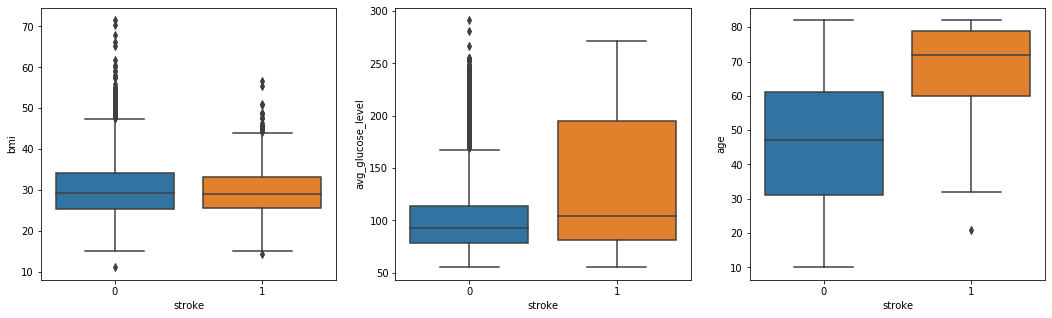

In [38]:
outlier_delete = train_delete.toPandas()

fig, axes_out_delete = plt.subplots(1,3, figsize=(18,5))

sns.boxplot(x = "stroke", y = "bmi", data=outlier_delete, ax=axes_out_delete[0])
sns.boxplot(x = "stroke", y = "avg_glucose_level", data=outlier_delete, ax=axes_out_delete[1])
sns.boxplot(x = "stroke", y = "age", data=outlier_delete, ax=axes_out_delete[2])
plt.show()

Now there is no missing values, Lets work on categorical columns now...

StringIndexer -> OneHotEncoder -> VectorAssembler

In [0]:
# indexing all categorical columns in the dataset
from pyspark.ml.feature import StringIndexer
indexer1 = StringIndexer(inputCol="gender", outputCol="genderIndex")
indexer2 = StringIndexer(inputCol="ever_married", outputCol="ever_marriedIndex")
indexer3 = StringIndexer(inputCol="work_type", outputCol="work_typeIndex")
indexer4 = StringIndexer(inputCol="Residence_type", outputCol="Residence_typeIndex")
indexer5 = StringIndexer(inputCol="smoking_status", outputCol="smoking_statusIndex")


In [0]:
# Doing one hot encoding of indexed data
from pyspark.ml.feature import OneHotEncoderEstimator
encoder = OneHotEncoderEstimator(inputCols=["genderIndex","ever_marriedIndex","work_typeIndex","Residence_typeIndex","smoking_statusIndex"],
                                 outputCols=["genderVec","ever_marriedVec","work_typeVec","Residence_typeVec","smoking_statusVec"])

The next step is to create an assembler, that combines a given list of columns into a single vector column to train ML model. I will use the vector columns, that we got after one_hot_encoding.

In [41]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['genderVec',
 'age',
 'hypertension',
 'heart_disease',
 'ever_marriedVec',
 'work_typeVec',
 'Residence_typeVec',
 'avg_glucose_level',
 'bmi',
 'smoking_statusVec'],outputCol='features')
assembler

VectorAssembler_d2d13e0c1181

### Classification (Decision Tree)

We are using Decision tree classifier for baseline model

In [0]:
from pyspark.ml.classification import DecisionTreeClassifier
dtc = DecisionTreeClassifier(labelCol='stroke',featuresCol='features')

So far we have kind of a complex task that contains bunch of stages, that need to be performed to process data. To wrap all of that Spark ML represents such a workflow as a Pipeline, which consists of a sequence of PipelineStages to be run in a specific order.

In [0]:
from pyspark.ml import Pipeline
pipeline = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, dtc])

The next step is to split dataset to train and test to train the model and make predictions.

In [0]:
# splitting training and validation data
train_data,val_data = train_f.randomSplit([0.7,0.3])

# training model pipeline with data
model = pipeline.fit(train_data)

Now we will evaluate the model with validation data

In [106]:
# making prediction on model with validation data
dtc_predictions = model.transform(val_data)

# Select example rows to display.
dtc_predictions.select("prediction","probability", "stroke", "features").show(5)

+----------+--------------------+------+--------------------+
|prediction|         probability|stroke|            features|
+----------+--------------------+------+--------------------+
|       0.0|[0.98108925869894...|     0|(16,[0,2,6,10,11,...|
|       0.0|[0.57142857142857...|     1|(16,[1,2,5,7,10,1...|
|       1.0|[0.36842105263157...|     1|(16,[1,2,5,7,11,1...|
|       0.0|[0.87234042553191...|     0|(16,[1,2,5,6,11,1...|
|       0.0|[0.98108925869894...|     0|(16,[0,2,6,10,11,...|
+----------+--------------------+------+--------------------+
only showing top 5 rows



In [107]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
dtc_acc = acc_evaluator.evaluate(dtc_predictions)
print('A Decision Tree algorithm had an accuracy of: {0:2.2f}%'.format(dtc_acc*100))

A Decision Tree algorithm had an accuracy of: 81.56%


In [108]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(dtc_predictions)
print("F1 = %g" % f1)

F1 = 0.812439


In [147]:
# now predicting the labels for test data
test_pred = model.transform(test_f)
test_selected = test_pred.select("id", "features", "prediction")
test_selected.limit(10).toPandas()

,id,features,prediction
0,36306,"(0.0, 1.0, 80.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0,...",0.0
1,61829,"(1.0, 0.0, 74.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0,...",0.0
2,14152,"(1.0, 0.0, 14.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0.0
3,12997,"(0.0, 1.0, 28.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0,...",0.0
4,40801,"(1.0, 0.0, 63.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...",0.0
5,9348,"(1.0, 0.0, 66.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0,...",0.0
6,51550,"(1.0, 0.0, 49.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",0.0
7,60512,"(0.0, 1.0, 46.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0,...",0.0
8,31309,"(1.0, 0.0, 75.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",1.0
9,39199,"(0.0, 1.0, 75.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0,...",1.0


In [111]:
predict_p_dt = test_pred.select("id", "prediction", "probability", "features").toPandas()
a = 0

for i in range(predict_p_dt.count().probability) :
  a = a + predict_p_dt.probability[i][0]

p_dt_mean = a/(predict_p_dt.count().probability)
print('A Decision Tree had an accuracy of {0:2.4f}%'.format(p_dt_mean*100) + ' using independent test set')

A Decision Tree had an accuracy of 85.7350% using independent test set


###Predictor (Logistic Regression)

####With imputation


In [0]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(labelCol="stroke",featuresCol="features",maxIter=10)

from pyspark.ml import Pipeline
pipeline2 = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, lr])

In [0]:
# splitting training and validation data
train_data_lr,val_data_lr = train_f.randomSplit([0.7,0.3])

# training model pipeline with data
model_lr = pipeline2.fit(train_data_lr)

In [118]:
# making prediction on model with validation data
lr_predictions = model_lr.transform(val_data_lr)

# Select example rows to display.
lr_predictions.select("stroke", "prediction","probability", "features").show(5)

+------+----------+--------------------+--------------------+
|stroke|prediction|         probability|            features|
+------+----------+--------------------+--------------------+
|     0|       0.0|[0.97721198611071...|(16,[0,2,6,10,11,...|
|     0|       0.0|[0.99842824315361...|(16,[0,2,9,11,12,...|
|     0|       0.0|[0.90357031763867...|(16,[0,2,5,6,10,1...|
|     0|       0.0|[0.99058247322944...|(16,[0,2,6,10,11,...|
|     0|       0.0|[0.99860921629977...|(16,[0,2,9,11,12,...|
+------+----------+--------------------+--------------------+
only showing top 5 rows



In [119]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
acc_evaluator_lr = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
lr_acc = acc_evaluator_lr.evaluate(lr_predictions)
print('A Logistic Regression with imputation had an accuracy of: {0:2.4f}%'.format(lr_acc*100))

A Logistic Regression with imputation had an accuracy of: 83.9783%


In [120]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(lr_predictions)
print("F1 = %g" % f1)

F1 = 0.82951


In [121]:
predict_test = model.transform(test_f)
predict_test.select("id", "prediction","probability").limit(10).toPandas()

,id,prediction,probability
0,36306,0.0,"[0.5714285714285714, 0.42857142857142855]"
1,61829,0.0,"[0.5714285714285714, 0.42857142857142855]"
2,14152,0.0,"[0.981089258698941, 0.018910741301059002]"
3,12997,0.0,"[0.981089258698941, 0.018910741301059002]"
4,40801,0.0,"[0.8723404255319149, 0.1276595744680851]"
5,9348,0.0,"[0.6666666666666666, 0.3333333333333333]"
6,51550,0.0,"[0.8723404255319149, 0.1276595744680851]"
7,60512,0.0,"[0.8723404255319149, 0.1276595744680851]"
8,31309,1.0,"[0.432258064516129, 0.567741935483871]"
9,39199,1.0,"[0.432258064516129, 0.567741935483871]"


In [122]:
predict_test_p = predict_test.select("id", "prediction","probability", "features").toPandas()
a = 0

for i in range(predict_test_p.count().probability) :
  a = a + predict_test_p.probability[i][0]

p_mean = a/(predict_test_p.count().probability)
print('A Logistic Regression algorithm with imputation had prediction probability of {0:2.4f}%'.format(p_mean*100) + ' using independent test set')

A Logistic Regression algorithm with imputation had prediction probability of 85.7350% using independent test set


In [102]:
print("Coefficients: ", model_lr.stages[-1].coefficients)
print("Intercepts:", str(model_lr.stages[-1].intercept))

Coefficients:  [-1.596925742757241,-1.3555589065577358,0.07465284067507821,0.3528583778924133,0.9066054178632676,-0.6231344528967676,-0.8116235691945479,-0.8739578790110162,-2.8024457199412205,-0.8399523002346109,0.13536258388176234,0.0026651555772316928,-0.023053229849737907,-0.7268465954143414,-0.4637350791726219,-0.502838803169115]
Intercepts: -2.226285833066799


####Without imputation (Delete rows which have missing values)

In [0]:
from pyspark.ml.classification import LogisticRegression
lr_del = LogisticRegression(labelCol="stroke",featuresCol="features",maxIter=10)

from pyspark.ml import Pipeline
pipeline3 = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, lr_del])

In [0]:
# splitting training and validation data
train_data_del,val_data_del = train_delete.randomSplit([0.7,0.3])

# training model pipeline with data
model_del = pipeline3.fit(train_data_del)

In [132]:
# making prediction on model with validation data
lr_del_predictions = model_del.transform(val_data_del)

# Select example rows to display.
lr_del_predictions.select("stroke", "prediction","probability", "features").show(5)

+------+----------+--------------------+--------------------+
|stroke|prediction|         probability|            features|
+------+----------+--------------------+--------------------+
|     1|       0.0|[0.55843917078411...|(15,[1,2,5,7,10,1...|
|     1|       0.0|[0.54550100964652...|(15,[1,2,5,7,11,1...|
|     1|       0.0|[0.70335855490855...|(15,[0,2,5,7,10,1...|
|     0|       0.0|[0.56635063816521...|(15,[1,2,5,6,11,1...|
|     0|       0.0|[0.88792835937719...|(15,[1,2,5,6,11,1...|
+------+----------+--------------------+--------------------+
only showing top 5 rows



In [133]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
acc_evaluator_lr_del = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
lr_del_acc = acc_evaluator_lr_del.evaluate(lr_del_predictions)
print('A Logistic Regression without imputation had an accuracy of: {0:2.4f}%'.format(lr_del_acc*100))

A Logistic Regression without imputation had an accuracy of: 80.7783%


In [134]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(lr_del_predictions)
print("F1 = %g" % f1)

F1 = 0.780562


In [135]:
predict_test_del = model.transform(test_delete)
predict_test_del.select("id", "prediction","probability").limit(10).toPandas()

,id,prediction,probability
0,36306,0.0,"[0.5714285714285714, 0.42857142857142855]"
1,61829,0.0,"[0.5714285714285714, 0.42857142857142855]"
2,40801,0.0,"[0.8723404255319149, 0.1276595744680851]"
3,9348,0.0,"[0.6666666666666666, 0.3333333333333333]"
4,60512,0.0,"[0.8723404255319149, 0.1276595744680851]"
5,31309,1.0,"[0.432258064516129, 0.567741935483871]"
6,39199,1.0,"[0.432258064516129, 0.567741935483871]"
7,19042,0.0,"[0.8723404255319149, 0.1276595744680851]"
8,33104,0.0,"[0.6666666666666666, 0.3333333333333333]"
9,55264,0.0,"[0.8723404255319149, 0.1276595744680851]"


In [136]:
predict_test_del_p = predict_test_del.select("id", "prediction","probability", "features").toPandas()
a = 0

for i in range(predict_test_del_p.count().probability) :
  a = a + predict_test_del_p.probability[i][0]

del_p_mean = a/(predict_test_del_p.count().probability)
print('A Logistic Regression algorithm without imputation had prediction probability of {0:2.4f}%'.format(del_p_mean*100) + ' using independent test set')

A Logistic Regression algorithm without imputation had prediction probability of 84.0559% using independent test set


In [137]:
print("Coefficients: ", model_del.stages[-1].coefficients)
print("Intercepts:", str(model_del.stages[-1].intercept))

Coefficients:  [-1.5343536529373494,-1.3544346532429141,0.07556839889038569,0.4097004751142307,0.637012764764908,-0.7148189154618536,-1.2099511701435766,-1.2082620778549127,-1.211744243521239,-2.7449546435436756,0.026084509402923086,0.002573425587776823,-0.009301458211343186,-0.7555722448665145,-0.7373523073591269]
Intercepts: -2.213966973129203


### K-mean Clustering

In [0]:
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.clustering import KMeans
# a k-means model.
kmeans = KMeans().setK(2).setSeed(1)

# Loads data.
pipeline4 = Pipeline(stages=[indexer1, indexer2, indexer3, indexer4, indexer5, encoder, assembler, kmeans])

train_data_k,val_data_k = train_f.randomSplit([0.7,0.3])

# Trains a k-means model.
kmean_predictor = pipeline4.fit(train_data_k)

# Make predictions
kmean_predictions = kmean_predictor.transform(val_data_k)

In [139]:
kmena_output_df = kmean_predictions.withColumn("prediction",kmean_predictions["prediction"].cast('double'))
#.withColumn("stroke",kmean_predictions["stroke"].cast('double'))
test_selected = kmena_output_df.select("id", "features", "prediction","stroke")
test_selected.show(10)

+----+--------------------+----------+------+
|  id|            features|prediction|stroke|
+----+--------------------+----------+------+
|  38|(16,[0,2,6,10,11,...|       0.0|     0|
|  61|(16,[1,2,3,6,11,1...|       0.0|     0|
| 312|(16,[0,2,5,6,10,1...|       0.0|     0|
| 573|(16,[1,2,4,7,11,1...|       1.0|     1|
| 712|(16,[0,2,3,4,6,11...|       0.0|     1|
| 714|(16,[0,2,5,6,11,1...|       0.0|     1|
| 756|(16,[0,2,6,10,11,...|       0.0|     0|
| 919|(16,[0,2,3,5,7,11...|       0.0|     1|
|1010|(16,[1,2,8,11,12,...|       0.0|     0|
|1081|(16,[0,2,3,5,6,10...|       1.0|     1|
+----+--------------------+----------+------+
only showing top 10 rows



In [140]:
# Evaluate clustering by computing Silhouette score
evaluator = ClusteringEvaluator()

silhouette = evaluator.evaluate(kmean_predictions)
print("Silhouette with squared euclidean distance = " + str(silhouette))

Silhouette with squared euclidean distance = 0.8464796298282147


In [141]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Select (prediction, true label) and compute test error
acc_evaluator = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="accuracy")
kmean_acc = acc_evaluator.evaluate(kmena_output_df)
print('A K-mean clustering algorithm had an accuracy of: {0:2.2f}%'.format(kmean_acc*100))

A K-mean clustering algorithm had an accuracy of: 76.80%


In [142]:
evaluatorf1 = MulticlassClassificationEvaluator(labelCol="stroke", predictionCol="prediction", metricName="f1")
f1 = evaluatorf1.evaluate(kmena_output_df)
print("F1 = %g" % f1)

F1 = 0.763383
